In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

### Function that will normalize the way the date is written on the files

In [26]:
def normalize_date(date_str):
    from datetime import datetime
    try:
        # Attempt to parse the date in various formats
        date_formats = ['_%Y_%m_%d', '_%y_%m_%d', '_%y_%m_%d']
        for fmt in date_formats:
            try:
                date_obj = datetime.strptime(date_str, fmt)
                return date_obj.strftime('%Y-%m-%d')
            except ValueError:
                pass  # Continue to next format
        # If none of the formats match, return None
        return None
    except Exception as e:
        print(f"Error occurred while parsing date: {e}")
        return None

### Function that will read the .dat files

In [5]:
def read_dat_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Find the index of the line that says '#BEGIN DATA'
    data_start_index = next(i for i, line in enumerate(lines) if '#BEGIN DATA' in line)
    
    # Initialize lists to store trial data
    start_zones = []
    end_zones = []
    stops = []
    prods = []
    
    # Process lines after '#BEGIN DATA'
    i = data_start_index + 1
    while i < len(lines):
        line = lines[i].strip().split(',')
        if len(line) < 2:
            i += 1
            continue

        # Parse the zone and value
        zone = line[1].strip()
        
        if zone == 'EOF':
            break
        elif zone == 'n':
            # Skip trial if it contains 'n'
            i += 1
            continue
        elif zone == 'f':
            # Confirm end of trial, move to next trial
            i += 1
            continue
        elif zone.isdigit():
            zone = int(zone)
            if len(start_zones) == len(end_zones):
                start_zones.append(zone)
                stops.append(0)
                prods.append(0)
            else:
                end_zones.append(zone)
        elif zone == 's':
            stops[-1] += 1
        elif zone == 'p':
            prods[-1] += 1
        i += 1
    
    # Create a DataFrame from the collected data
    trial_data = pd.DataFrame({
        'Start_Zone': start_zones,
        'End_Zone': end_zones,
        'Stops': stops,
        'Prods': prods
    })
    
    return trial_data

In [4]:
print(read_dat_file("X:\MATT_SCORING\RMB4_2023_07_09.dat"))

## Here we will input the rewarded zone.
### With the function ErrorScore we will determine the difference between the end zone (second in each pair) and the Rewarded Zone (RewZone)

In [6]:
def ErrorScore(data_path, RewZone):
    errors = []
    trial_data = read_dat_file(data_path)
    for index, row in trial_data.iterrows():
        start_zone = row['Start_Zone']
        end_zone = row['End_Zone']
        
        if end_zone == RewZone:
            error = 0
        else:
            error = (end_zone - RewZone) % 8
            if error > 4:
                error -= 8
        
        errors.append(error)
    
    trial_data['Error'] = errors
    return trial_data

In [6]:
a = ErrorScore("X:\MATT_SCORING\RMB4_2023_07_09.dat", 5)
print(a)

### Iteration function
#### This function will iterate through a folder of your choice and look for .dat files whose name starts with the string you also input, which should be the ID of the animal. 
#### The function will create txt files that will have the vector created by ErrorScore

In [13]:
def process_files_in_folder(folder_path, RewZone):
    file_prefix = 'RMB'
    # Find all .dat files starting with the given prefix in the specified folder
    search_pattern = os.path.join(folder_path, f'{file_prefix}*.dat')
    dat_files = glob.glob(search_pattern)

    all_results = []

    for dat_file in dat_files:
        # Read data from the .dat file
        trial_data = read_dat_file(dat_file)
        
        if not trial_data.empty:
            # Calculate error scores and create DataFrame
            df = ErrorScore(dat_file, RewZone)
            
            # Extract the date from the filename
            base_name = os.path.basename(dat_file)
            date_part = base_name.replace(file_prefix, '').replace('.dat', '')
            normalized_day = normalize_date(date_part)
            # Add Date column to DataFrame
            df.insert(0, 'Date', normalized_day)
            
            # Append DataFrame to all_results
            all_results.append(df)

    # Concatenate all DataFrames into one
    result_df = pd.concat(all_results, ignore_index=True)

    # Add Date and Trial indices
    result_df['Date_Index'] = result_df.groupby('Date').ngroup() + 1
    result_df['Trial_Index'] = result_df.groupby('Date').cumcount() + 1
    
    # Save the DataFrame to a CSV file
    output_filename = os.path.join(folder_path, f'MEA_Results_{os.path.basename(folder_path)}.csv')
    result_df.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")
    
    classify_errors(output_filename)

In [8]:
folder_path = 'X:\MATT_SCORING'  # Replace with the path to your folder
file_prefix = 'RMB4'  # Example file prefix to look for
RewZone = 5  # Example value for RewZone
process_files_in_folder(folder_path, file_prefix, RewZone)

In [ ]:
def plot_mean_absolute_error_with_sem(csv_file):

    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Drop rows with invalid dates
    df = df.dropna(subset=['Date'])
    
    # Calculate the absolute error
    df['Absolute Error'] = df['Error'].abs()
    
    # Group by date and calculate the mean absolute error and SEM
    grouped = df.groupby('Date')['Absolute Error']
    mean_absolute_error = grouped.mean().reset_index()
    sem_absolute_error = grouped.sem().reset_index()
    
    # Sort by date in ascending order
    mean_absolute_error = mean_absolute_error.sort_values(by='Date')
    sem_absolute_error = sem_absolute_error.sort_values(by='Date')
    
    # Plot the mean absolute error with SEM as shaded ribbon
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=mean_absolute_error, x='Date', y='Absolute Error', marker='o')
    plt.fill_between(mean_absolute_error['Date'], mean_absolute_error['Absolute Error'] - sem_absolute_error['Absolute Error'], mean_absolute_error['Absolute Error'] + sem_absolute_error['Absolute Error'], alpha=0.3)
    plt.xlabel('Date')
    plt.ylabel('Mean Absolute Error')
    plt.title('Mean Absolute Error by Date with SEM (Ribbon Plot)')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [10]:
csv_file = "X:\MATT_SCORING\MEA_Results_RMB4.csv"  # Replace with the path to your CSV file
plot_mean_absolute_error_with_sem(csv_file)

In [14]:
def classify_errors(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Initialize an empty list to store error classifications
    error_types = []
    
    # Initialize variables to keep track of the previous trial's data
    prev_error = None
    prev_motion = None
    
    # Iterate over rows in the DataFrame
    for index, row in df.iterrows():
        # Current trial's data
        current_error = row['Error']
        current_motion = row['End_Zone'] - row['Start_Zone']
        
        # Handle the first row separately
        if index == 0:
            # Check if the first trial is correct
            if current_error == 0:
                error_type = 'Correct'
            else:
                error_type = 'NA'  # Not Applicable for the first row
        else:
            # Check if the current trial is correct
            if current_error == 0:
                error_type = 'Correct'
            else:
                # Check conditions for error classification
                if prev_error == 0 and current_motion == prev_motion:
                    error_type = 'ECS'  # Egocentric Centered Strategy
                elif prev_error != 0 and current_motion == prev_motion:
                    error_type = 'NFES'  # Non-flexible Egocentric Strategy
                elif abs(current_error) == 1:
                    error_type = 'IT'  # Inexact Transformation
                else:
                    error_type = 'RS'  # Random Strategy
        
        # Append error type to the list
        error_types.append(error_type)
        
        # Update previous trial's data for the next iteration
        prev_error = current_error
        prev_motion = current_motion
    
    # Add the Error_Type column to the DataFrame
    df['Error_Type'] = error_types
    
    # Save the DataFrame back to the CSV file
    df.to_csv(csv_file, index=False)

In [12]:
csv_file = "X:\MATT_SCORING\MEA_Results_RMB4.csv"  # Replace with the path to your CSV file
classify_errors(csv_file)

In [10]:
def plot_error_frequency(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Group the data by date and error type, and count the occurrences
    error_counts = df.groupby(['Date', 'Error_Type']).size().unstack(fill_value=0)
    error_counts = error_counts.drop(columns='Correct', errors='ignore')
    
    plt.figure(figsize=(15, 8))
    # Plot each error type separately
    for error_type in error_counts.columns:
        plt.plot(error_counts.index, error_counts[error_type], label=error_type)

    # Set plot labels and title
    
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.title('Error Frequency by Date')
    plt.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Show the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [14]:
csv_file = "X:\MATT_SCORING\RMB1_5\MEA_Results_RMB1.csv"  # Replace with the path to your CSV file
plot_error_frequency(csv_file)

In [11]:
def plot_stack_bar_error_frequency(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Group the data by date and error type, and count the occurrences
    error_counts = df.groupby(['Date', 'Error_Type']).size().unstack(fill_value=0)
    
    # Exclude the 'Correct' error type from the plot
    error_counts = error_counts.drop(columns='Correct', errors='ignore')
    
    # Plot the frequency of each error type for each date
    error_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    # Set plot labels and title
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.title('Error Frequency by Date')
    plt.legend(title='Error Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Show the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [16]:
csv_file = "X:\MATT_SCORING\RMB1_5\MEA_Results_RMB1.csv"  # Replace with the path to your CSV file
plot_stack_bar_error_frequency(csv_file)

In [18]:
def plot_error_percentage(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Filter out the 'Correct' error type
    df_incorrect = df[df['Error_Type'] != 'Correct']
    
    # Group the data by error type and count the occurrences
    error_counts = df_incorrect['Error_Type'].value_counts()
    
    # Calculate the percentage of each error type relative to the total incorrect trials
    error_percentage = error_counts / error_counts.sum() * 100
    
    # Define colors for each error type
    error_colors = {'ECS': 'blue', 'IT': 'orange', 'NFES': 'green', 'RS': 'red'}
    
    # Plot the percentage of each error type with customized colors
    error_percentage.plot(kind='bar', figsize=(10, 6), color=[error_colors.get(x, 'gray') for x in error_percentage.index])
    
    # Set plot labels and title
    plt.xlabel('Error Type')
    plt.ylabel('Percentage')
    plt.title('Error Percentage Across All Dates (Incorrect Trials Only)')
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [243]:
csv_file = "X:\MATT_SCORING\RMB1_3\MEA_Results_RMB1.csv"  # Replace with the path to your CSV file
plot_error_percentage(csv_file)

In [244]:
csv_file = "X:\MATT_SCORING\RMB1_5\MEA_Results_RMB1.csv"  # Replace with the path to your CSV file
plot_error_percentage(csv_file)

In [19]:
csv_file = "X:\MATT_SCORING\MEA_Results_RMB4.csv"
plot_error_percentage(csv_file)

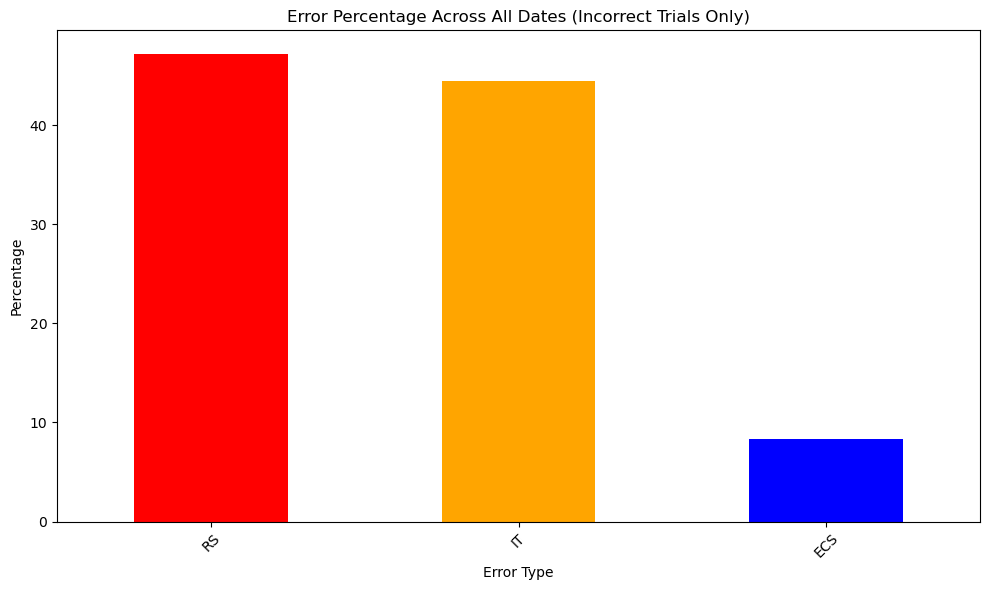

In [235]:
csv_file = "X:\MATT_SCORING\MEA_Results_RMB2.csv"
plot_error_percentage(csv_file)

In [15]:
def process_all_subfolders(root_folder):
    subfolders = [f.path for f in os.scandir(root_folder) if f.is_dir()]
    for subfolder in subfolders:
        folder_name = os.path.basename(subfolder)
        parts = folder_name.split('_')
        if len(parts) == 2 and parts[1].isdigit():
            animal_id, rew_zone = parts
            rew_zone = int(rew_zone)
            process_files_in_folder(subfolder, rew_zone)



In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns

def normalize_date(date_str):
    from datetime import datetime
    date_formats = ['_%Y_%m_%d', '_%y_%m_%d']
    for fmt in date_formats:
        try:
            date_obj = datetime.strptime(date_str, fmt)
            return date_obj.strftime('%Y-%m-%d')
        except ValueError:
            continue
    print(f"Failed to parse date: {date_str}")
    return None

def extract_date_from_filename(filename):
    parts = filename.split('_')
    if len(parts) >= 3:
        date_part = '_' + '_'.join(parts[-3:]).replace('.dat', '')
        normalized_date = normalize_date(date_part)
        return normalized_date
    return None

def read_dat_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data_start_index = next(i for i, line in enumerate(lines) if '#BEGIN DATA' in line)
    
    start_zones = []
    end_zones = []
    stops = []
    prods = []
    
    i = data_start_index + 1
    while i < len(lines):
        line = lines[i].strip().split(',')
        if len(line) < 2:
            i += 1
            continue

        zone = line[1].strip()
        
        if zone == 'EOF':
            break
        elif zone == 'n':
            i += 1
            continue
        elif zone == 'f':
            i += 1
            continue
        elif zone.isdigit():
            zone = int(zone)
            if len(start_zones) == len(end_zones):
                start_zones.append(zone)
                stops.append(0)
                prods.append(0)
            else:
                end_zones.append(zone)
        elif zone == 's':
            stops[-1] += 1
        elif zone == 'p':
            prods[-1] += 1
        i += 1
    
    min_length = min(len(start_zones), len(end_zones), len(stops), len(prods))
    start_zones = start_zones[:min_length]
    end_zones = end_zones[:min_length]
    stops = stops[:min_length]
    prods = prods[:min_length]
    
    trial_data = pd.DataFrame({
        'Start_Zone': start_zones,
        'End_Zone': end_zones,
        'Stops': stops,
        'Prods': prods
    })
    
    return trial_data

def ErrorScore(data_path, RewZone):
    errors = []
    trial_data = read_dat_file(data_path)
    for index, row in trial_data.iterrows():
        start_zone = row['Start_Zone']
        end_zone = row['End_Zone']
        
        if end_zone == RewZone:
            error = 0
        else:
            error = (end_zone - RewZone) % 8
            if error > 4:
                error -= 8
        
        errors.append(error)
    
    trial_data['Error'] = errors
    return trial_data

def process_files_in_folder(folder_path, RewZone):
    file_prefix = 'RMB'
    search_pattern = os.path.join(folder_path, f'{file_prefix}*.dat')
    dat_files = glob.glob(search_pattern)

    all_results = []

    for dat_file in dat_files:
        trial_data = read_dat_file(dat_file)
        
        if not trial_data.empty:
            df = ErrorScore(dat_file, RewZone)
            
            base_name = os.path.basename(dat_file)
            normalized_day = extract_date_from_filename(base_name)

            if normalized_day:
                df.insert(0, 'Date', normalized_day)
            
                all_results.append(df)

    if all_results:
        result_df = pd.concat(all_results, ignore_index=True)
    
        # Index the date as 1 through whatever number
        result_df['Date_Index'] = result_df.groupby('Date').ngroup() + 1
        
        # Index the trials within each date from 1 to whatever number
        result_df['Trial_Index'] = result_df.groupby('Date').cumcount() + 1
    
        output_filename = os.path.join(folder_path, f'MEA_Results_{os.path.basename(folder_path)}.csv')
        result_df.to_csv(output_filename, index=False)
        print(f"Results saved to {output_filename}")
        
        classify_errors(output_filename)

def classify_errors(csv_file):
    df = pd.read_csv(csv_file)
    
    error_types = []
    
    prev_error = None
    prev_motion = None
    
    for index, row in df.iterrows():
        current_error = row['Error']
        current_motion = row['End_Zone'] - row['Start_Zone']
        
        if index == 0:
            if current_error == 0:
                error_type = 'Correct'
            else:
                error_type = 'NA'
        else:
            if current_error == 0:
                error_type = 'Correct'
            else:
                if prev_error == 0 and current_motion == prev_motion:
                    error_type = 'ECS'
                elif prev_error != 0 and current_motion == prev_motion:
                    error_type = 'NFES'
                elif abs(current_error) == 1:
                    error_type = 'IT'
                else:
                    error_type = 'RS'
        
        error_types.append(error_type)
        
        prev_error = current_error
        prev_motion = current_motion
    
    df['Error_Type'] = error_types
    
    df.to_csv(csv_file, index=False)

def process_all_subfolders(root_folder):
    subfolders = [f.path for f in os.scandir(root_folder) if f.is_dir()]
    for subfolder in subfolders:
        folder_name = os.path.basename(subfolder)
        parts = folder_name.split('_')
        if len(parts) == 2 and parts[1].isdigit():
            animal_id, rew_zone = parts
            rew_zone = int(rew_zone)
            process_files_in_folder(subfolder, rew_zone)

root_folder = 'X:/MATT_SCORING'  # Replace with the path to your folder
process_all_subfolders(root_folder)


Results saved to X:/MATT_SCORING\RMB10_3\MEA_Results_RMB10_3.csv
Results saved to X:/MATT_SCORING\RMB10_8\MEA_Results_RMB10_8.csv
Results saved to X:/MATT_SCORING\RMB1_3\MEA_Results_RMB1_3.csv
Results saved to X:/MATT_SCORING\RMB1_5\MEA_Results_RMB1_5.csv
Results saved to X:/MATT_SCORING\RMB2_5\MEA_Results_RMB2_5.csv
Results saved to X:/MATT_SCORING\RMB2_7\MEA_Results_RMB2_7.csv
Results saved to X:/MATT_SCORING\RMB3_4\MEA_Results_RMB3_4.csv
Results saved to X:/MATT_SCORING\RMB3_7\MEA_Results_RMB3_7.csv
Results saved to X:/MATT_SCORING\RMB4_3\MEA_Results_RMB4_3.csv
Results saved to X:/MATT_SCORING\RMB4_7\MEA_Results_RMB4_7.csv
Results saved to X:/MATT_SCORING\RMB5_4\MEA_Results_RMB5_4.csv
Results saved to X:/MATT_SCORING\RMB5_7\MEA_Results_RMB5_7.csv
Results saved to X:/MATT_SCORING\RMB6_8\MEA_Results_RMB6_8.csv
Results saved to X:/MATT_SCORING\RMB7_3\MEA_Results_RMB7_3.csv
Results saved to X:/MATT_SCORING\RMB7_8\MEA_Results_RMB7_8.csv
Results saved to X:/MATT_SCORING\RMB8_2\MEA_Results

In [38]:
def combine_csv_files(root_folder):
    all_data = []
    
    for subdir, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(subdir, file)
                df = pd.read_csv(file_path)
                animal_id = os.path.basename(subdir).split('_')[0]
                df['Animal_ID'] = animal_id
                all_data.append(df)
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_filename = os.path.join(root_folder, 'combined_data.csv')
        combined_df.to_csv(combined_filename, index=False)
        print(f"Combined data saved to {combined_filename}")
    else:
        print("No CSV files found in the specified folder.")

root_folder = 'X:/MATT_SCORING'  # Replace with the root path to your folder containing all the CSVs
combine_csv_files(root_folder)

In [46]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the combined dataset
combined_data = pd.read_csv("X:\MATT_SCORING\combined_data.csv")

# Convert Animal_ID, Age, and Group to categorical data type
combined_data['Animal_ID'] = combined_data['Animal_ID'].astype('category')
combined_data['Age'] = combined_data['Age'].astype('category')
combined_data['Group'] = combined_data['Group'].astype('category')

# Define the formula for the linear mixed model
formula = 'Error ~ C(Age) * C(Group)'

# Fit the linear mixed model
model = smf.mixedlm(formula, combined_data, groups=combined_data['Animal_ID'])
result = model.fit()

# Print the summary of the model
print(result.summary())

In [66]:
# Count the number of errors for each Error_Type within each ID and Age
error_counts = combined_data.groupby(['Animal_ID', 'Age', 'Error_Type', 'Group']).size().reset_index(name='Count')

# Calculate the mean and SEM across groups for each Age
summary_df = error_counts.groupby(['Age', 'Group', 'Error_Type']).agg({'Count': ['mean', 'sem']}).reset_index()
summary_df.columns = ['Age','Group', 'Error_Type', 'Mean', 'SEM']

age_categories = {6: '6 months', 9: '9 months'}

# Define functions for age category and order
def age_to_category(age):
    return age_categories.get(age, 'Other')  # Handle missing ages

summary_df['Age_Group'] = summary_df['Age'].apply(age_to_category)
summary_df['Age_Group'] = summary_df['Age_Group'].astype(str)  # Ensure string type

def get_age_group_order(df):
    # Get unique categories in the desired order (adjust order as needed)
    return ['6 months', '9 months', 'Other']

# Create the bar plot with error bars and faceting by Group
age_group_order = get_age_group_order(summary_df)
g = sns.FacetGrid(summary_df, col='Group', hue='Error_Type', col_wrap=2, palette='colorblind')
g.map(sns.barplot, x='Age_Group', y='Mean', ci='sem', order=age_group_order)

# Add labels and title
g.fig.suptitle('Mean Number of Errors by Age, Group, and Error Type', fontsize=12)  # Set suptitle for all subplots
g.fig.subplots_adjust(top=0.88)  # Adjust spacing between title and subplots

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

plt.show()

In [65]:
print(summary_df['Age_Group'].dtypes)